# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
from getRefXSecs import getXSecFor
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
import pyslha


pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandom.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [4]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0
dataDF['excludedRelic'] = dataDF['Omega'] > 0.13
#Xenon 1T curve (from micromegas):
data_1t_lnM = [1.790E+00, 1.885E+00, 2.006E+00, 2.148E+00, 2.297E+00, 2.449E+00, 2.598E+00, 2.783E+00, 2.961E+00, 3.117E+00, 3.302E+00, 3.444E+00, 3.614E+00, 3.796E+00, 4.037E+00, 4.268E+00, 4.581E+00, 4.904E+00, 5.178E+00, 5.441E+00, 5.768E+00, 6.095E+00, 6.369E+00, 6.550E+00, 6.891E+00]
data_1t_lnS = [1.040E+00, 2.794E-02,-1.003E+00,-2.035E+00,-2.888E+00,-3.591E+00,-4.144E+00,-4.717E+00,-5.111E+00,-5.326E+00,-5.458E+00,-5.486E+00,-5.440E+00,-5.375E+00,-5.178E+00,-4.982E+00,-4.711E+00,-4.412E+00,-4.150E+00,-3.925E+00,-3.598E+00,-3.270E+00,-3.009E+00,-2.812E+00,-2.485E+00]
xenonF = interp1d(data_1t_lnM,data_1t_lnS,
                  bounds_error=False,fill_value="extrapolate") #interpolate in log
@np.vectorize
def xenonUL(mDM):
    return 1e-8*np.exp(xenonF(np.log(mDM))) #90% upper limit on sigmaNucleon (pb)

rDD = (dataDF['Omega']/0.12)*(dataDF['proton_SI']+dataDF['neutron_SI'])/2.0
rDD = rDD/xenonUL(dataDF['mass.1000022'])
dataDF['excludedDD'] = (rDD > 1)

#### Add c*tau column for charginos

In [5]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Add ratio of total cross-section to wino cross-sections

In [6]:
pids = [[-1000024,1000024],[1000023,1000024],[-1000024,1000023]]
ratio = []
for index,row in dataDF.iterrows():    
    xsecRefSum = 0.0
    xsecSum = 0.0
    for pidpair in pids:
        mass1 = row['mass.%i'%abs(pidpair[0])] 
        mass2 = row['mass.%i'%abs(pidpair[1])] 
        mass = (mass1+mass2)/2.
        xsecRef = max(0,1000*getXSecFor(pidpair[0],pidpair[1],mass,13.0,'wino'))
        xsecRefSum += xsecRef
            
        xsecLabel = 'xsec13TeV(fb).%i_%i' %(pidpair[0],pidpair[1])
        try:
            xsec = row[xsecLabel]
        except:
            xsec = 0.0
        xsecSum += xsec
    if xsecRefSum:
        ratio.append(xsecSum/xsecRefSum)    
    else:
        ratio.append(0.0)

In [7]:
dataDF['xsecRatio'] = ratio

### Get points excluded:

In [8]:
excluded = dataDF[dataDF['excludedLHC'] == True]
excludedDM = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == True)]
excludedDD = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                    & (dataDF['excludedDD'] == True)]

allowed = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                 & (dataDF['excludedDD'] == False)]

allowedLHCDD = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False)]

allowedLHC = dataDF[(dataDF['excludedLHC'] == False)]

print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total excluded (relic) = %i'%(len(excludedDM)))
print('Total excluded (DD) = %i'%(len(excludedDD)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 96669
Total excluded (LHC) = 7348
Total excluded (relic) = 41245
Total excluded (DD) = 12347
Total allowed = 35729



### Create analysis label for excluded points

In [9]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels


In [10]:
print(excluded['label'].unique())

['CMS-EXO-19-010 (TDTM1F,TDTM2F)' 'ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'
 'ATLAS-SUSY-2018-06 (TChiWZ)' 'CMS-SUS-17-004 (TChiWZoff)'
 'CMS-SUS-17-004 (TChiWZ)' 'ATLAS-SUSY-2016-24 (TChiWZ)'
 'ATLAS-SUSY-2019-08 (TChiWH)' 'CMS-SUS-16-039 (TChiWZoff)'
 'ATLAS-SUSY-2018-32 (TChiWW)' 'CMS-SUS-13-006 (TChiWZoff)'
 'ATLAS-SUSY-2013-12 (TChiWZ)' 'ATLAS-SUSY-2017-03 (TChiWZ)']


### Get relevant official exclusion curves

In [11]:
excCurves = {}
excATLAS = np.genfromtxt('../EWino/data/HEPData-ins1641262-v4-Exclusion_contour_EW_2_obs_conv.txt',
                       names=True)

excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'] = np.array(list(zip(excATLAS['mC1_GeV'],1.967e-16/excATLAS['width_GeV'])))


excCurves['CMS-SUS-17-004 (TChiWZ)'] =  np.genfromtxt('../EWino/data/CMS_SUS_17_004_TChiWZ_obs.csv', 
                                                      delimiter=',')
excCurves['ATLAS-SUSY-2016-24 (TChiWZ)'] = np.genfromtxt('../EWino/data/HEPData-ins1658902-v1-Table_20.csv',
                       delimiter=',', skip_header=9)
excCurves['ATLAS-SUSY-2019-08 (TChiWH)'] = np.genfromtxt('../EWino/data/HEPData-ins1755298-v1-Observed_limit_1lbb.csv',
                       delimiter=',', skip_header=11)
excCurves['ATLAS-SUSY-2018-32 (TChiWW)'] = np.genfromtxt('../EWino/data/HEPData-ins1750597-v1-Exclusion_contour_(obs)_1.csv',
                       delimiter=',', skip_header=10)
excCurves['CMS-SUS-13-006 (TChiWZoff)'] = np.genfromtxt('../EWino/data/CMS_SUS_13_006_TChiWZ_obs.csv', 
                                                      delimiter=',')

excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'] = np.genfromtxt('../EWino/data/CMS_SUS_19_010_TChiWZ_obs.csv', 
                                                      delimiter=',')
#Fix column order:
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[0,1]] = excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[1,0]]
#Convert width to lifetime
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]= 1.967e-16/excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]

### Plot allowed points

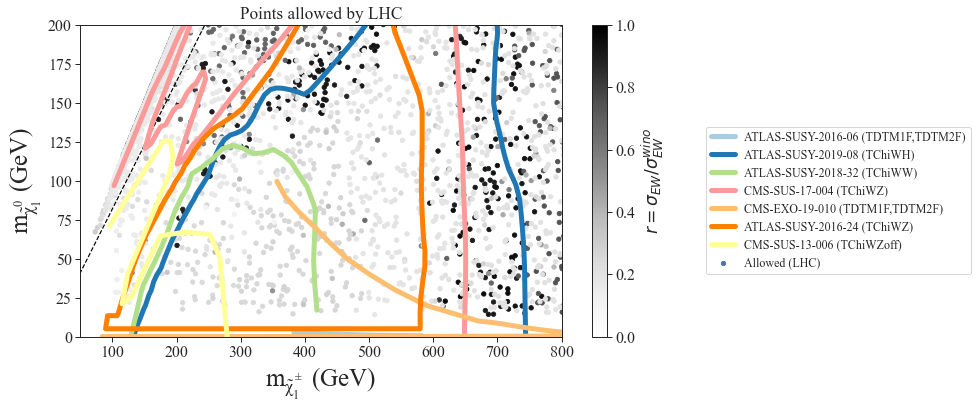

In [16]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
plt.figure(figsize=(14,6))

x = allowedLHC['mass.1000024']
y = allowedLHC['mass.1000022']
z = allowedLHC['xsecRatio']
cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Greys')
plt.scatter(x,y,c=z,label='Allowed (LHC)',s=20,cmap=cm,vmin=0,vmax=1)

plt.plot([0,500],[0,410],linestyle='--',c='black')


for ana in anas.index:
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=ana)
        

lgd = plt.legend(loc=(1.3,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,200)
plt.xlim(50,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$r = \sigma_{EW}/\sigma_{EW}^{wino}$')
plt.title("Points allowed by LHC")
plt.tight_layout()
plt.show()

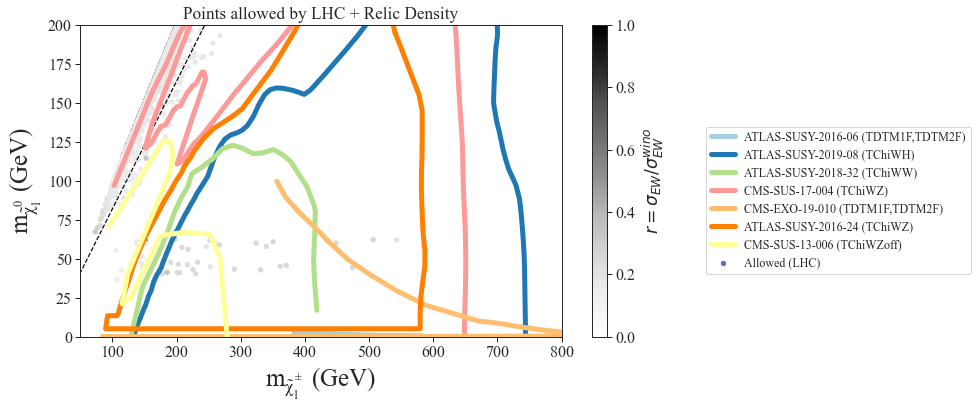

In [17]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
plt.figure(figsize=(14,6))

x = allowedLHCDD['mass.1000024']
y = allowedLHCDD['mass.1000022']
z = allowedLHCDD['xsecRatio']
cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Greys')
plt.scatter(x,y,c=z,label='Allowed (LHC)',s=20,cmap=cm,vmin=0,vmax=1)

plt.plot([0,500],[0,410],linestyle='--',c='black')


for ana in anas.index:
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=ana)
        

lgd = plt.legend(loc=(1.3,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,200)
plt.xlim(50,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$r = \sigma_{EW}/\sigma_{EW}^{wino}$')
plt.title("Points allowed by LHC + Relic Density")
plt.tight_layout()
plt.show()

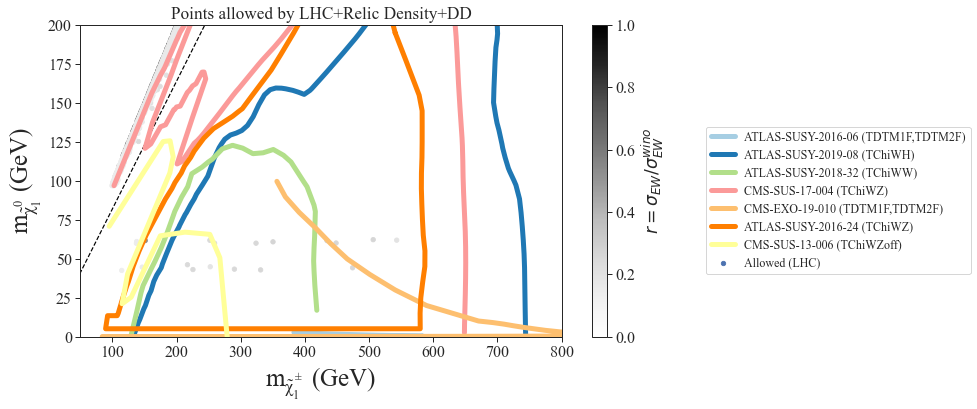

In [18]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
plt.figure(figsize=(14,6))

x = allowed['mass.1000024']
y = allowed['mass.1000022']
z = allowed['xsecRatio']
cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Greys')
plt.scatter(x,y,c=z,label='Allowed (LHC)',s=20,cmap=cm,vmin=0,vmax=1)

plt.plot([0,500],[0,410],linestyle='--',c='black')


for ana in anas.index:
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=ana)
        

lgd = plt.legend(loc=(1.3,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,200)
plt.xlim(50,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$r = \sigma_{EW}/\sigma_{EW}^{wino}$')
plt.title("Points allowed by LHC+Relic Density+DD")
plt.tight_layout()
plt.show()